In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def nrmse(actual, predicted):
    return np.sqrt(np.mean(np.square(actual - predicted))) / (actual.max() - actual.min())


def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

In [3]:
# reading data
train = []
test = []
with open('./dataset/2.txt', 'r') as f:
    M = int(f.readline())  # число признаков
    N = int(f.readline())  # число объектов в тренировочном наборе

    for i in range(N):
        train.append(list(map(int, f.readline().split(' '))))

    K = int(f.readline())  # число объектов в тестовом наборе

    for i in range(K):
        test.append(list(map(int, f.readline().split(' '))))

train = np.array(train, dtype='float64')
np.random.shuffle(train)
test = np.array(test, dtype='float64')

train = np.append(np.append(train[:, :-1], np.ones((N, 1)), axis=1), train[:, -1:], axis=1)
test = np.append(np.append(test[:, :-1], np.ones((K, 1)), axis=1), test[:, -1:], axis=1)

X_train = train[:, :-1]
y_train = train[:, -1:]

X_test = test[:, :-1]
y_test = test[:, -1:]

print('train: ', (X_train.shape, y_train.shape))
print('test: ', (X_test.shape, y_test.shape))

train:  ((8770, 58), (8770, 1))
test:  ((256, 58), (256, 1))


In [24]:
class GradientDescentRegressor:
    def __init__(self, lr=1e-9, max_iter=1000, penalty='l2', a=1, eps=1e-10):
        self.lr = lr
        self.max_iter = max_iter
        self.penalty = penalty
        self.a = a
        self.eps = eps

        self.w = None
        self.X = None
        self.y = None

    def _gradient(self, y_pred):
        l = len(self.X)
        return (2 / l) * self.X.T.dot(y_pred - self.y)

    def _cost(self, y_pred):
        return nrmse(self.y, y_pred)

    def fit(self, X, y):
        self.X = X
        self.y = y

        error_list = []
        self.w = np.zeros((X.shape[1], 1))

        for it in range(self.max_iter):
            y_pred = self.X.dot(self.w)

            if self.penalty == 'l1':
                self.w = self.w - self.lr * (self._gradient(y_pred) - 1 / self.a * np.sign(self.w))
            else:
                self.w = self.w - self.lr * (self._gradient(y_pred) - 1 / self.a * self.w)

            error_list.append(self._cost(y_pred))
            if it >= 2 and np.abs(error_list[-1] - error_list[-2]) < self.eps:
                break

        return self.w, error_list

    def predict(self, X_test):
        return X_test @ self.w


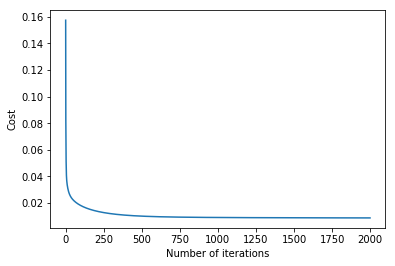

In [25]:
GDRegressor = GradientDescentRegressor(lr=5e-9, max_iter=2000, penalty='l2', a=1000, eps=1e-10)
_, err = GDRegressor.fit(X_train, y_train)

plt.plot(err)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [26]:
y_train_pred = GDRegressor.predict(X_train)

print('train nrmse: ', nrmse(y_train, y_train_pred))
print('train smape: ', smape(y_train, y_train_pred))
print(np.round(y_train[:18].flatten(), 0))
print(np.round(y_train_pred[:18].flatten(), 0))

train nrmse:  0.008691965470430272
train smape:  0.15100456661904127
[-16227033.  26458929.  30717789. -41676589.   4259140. -13429526.
   6228472. -17964692.  30556540.  -2459637.  15065655. -12145979.
  16819735.  -3823603.  37089485.  15040240.   8349853.  19601736.]
[-16272844.  27338897.  30403199. -41212861.   4062701. -16224358.
   5269230. -18541804.  29959286.  -3309476.  15081790. -12277107.
  16236199.  -4069992.  35201057.  15209932.   8130313.  18848691.]


In [27]:
y_test_pred = GDRegressor.predict(X_test)

print('test nrmse: ', nrmse(y_test, y_test_pred))
print('test smape: ', smape(y_test, y_test_pred))
print(np.round(y_test[:18].flatten(), 0))
print(np.round(y_test_pred[:18].flatten(), 0))

test nrmse:  0.002796215030768083
test smape:  0.04395566235912969
[-17999732. -12479108.   7480700. -16160833.   9688766.  -5795125.
  -1208631.   3092252.  37245198.  -1971175.  -5128219.   1385945.
   1755627.  16091113.  34019726.  19227534.  41983808.   8971134.]
[-18143473. -12482430.   7327517. -16414567.   9658926.  -5847778.
   -886244.   3175035.  37196685.  -1950766.  -5089066.   1592883.
   1742094.  15958368.  34048317.  19046980.  41532737.   8598430.]


In [8]:
class PseudoinverseRegressor:
    def __init__(self):
        self.theta = None

    def fit(self, X_train, y_train):
        self.theta = np.dot(np.linalg.pinv(X_train), y_train)
        return self.theta

    def predict(self, X_test):
        if self.theta is not None:
            return np.dot(X_test, self.theta)

In [9]:
pseudoinverseRegressor = PseudoinverseRegressor()
theta = pseudoinverseRegressor.fit(X_train, y_train)

In [10]:
y_train_pred = pseudoinverseRegressor.predict(X_train)

print('train nrmse: ', nrmse(y_train, y_train_pred))
print('train smape: ', smape(y_train, y_train_pred))
print(np.round(y_train[:18].flatten(), 0))
print(np.round(y_train_pred[:18].flatten(), 0))

train nrmse:  0.00848209703055794
train smape:  0.1497353492101201
[-16227033.  26458929.  30717789. -41676589.   4259140. -13429526.
   6228472. -17964692.  30556540.  -2459637.  15065655. -12145979.
  16819735.  -3823603.  37089485.  15040240.   8349853.  19601736.]
[-16198650.  27326834.  30582840. -41241114.   4144915. -16302224.
   5450456. -18444737.  30189125.  -3527776.  15268611. -12346867.
  16071108.  -3892629.  35645948.  15570550.   8195072.  19004770.]


In [11]:
y_test_pred = pseudoinverseRegressor.predict(X_test)

print('test nrmse: ', nrmse(y_test, y_test_pred))
print('test smape: ', smape(y_test, y_test_pred))
print(np.round(y_test[:18].flatten(), 0))
print(np.round(y_test_pred[:18].flatten(), 0))

test nrmse:  0.0008186815356768526
test smape:  0.018362450783921788
[-17999732. -12479108.   7480700. -16160833.   9688766.  -5795125.
  -1208631.   3092252.  37245198.  -1971175.  -5128219.   1385945.
   1755627.  16091113.  34019726.  19227534.  41983808.   8971134.]
[-17937992. -12401185.   7365206. -16111107.   9694056.  -5931285.
  -1247148.   3006786.  37196553.  -1972219.  -5110066.   1522012.
   1650091.  15944753.  33977606.  19095647.  41975271.   8879875.]


In [12]:
def annealing(X, y, lr=0.1):
    error_list = []
    t = 1.0
    weights = np.array([np.random.uniform(X[:, i].min(), X[:, i].max()) for i in range(len(X[0]))], copy=True)
    while t > 0.1:

        e_old = nrmse(y, X @ weights)

        new_weights = weights.copy()
        for i in range(len(X[0])):
            dir = np.random.choice([-1, 1])
            new_weights[i] = new_weights[i] - (dir * lr * new_weights[i])

        e_new = nrmse(y, X @ new_weights)

        if e_new < e_old or np.exp(-(e_new - e_old) / t) > np.random.rand():
            weights = new_weights.copy()
            e = e_new
        else:
            e = e_old

        error_list.append(e)
        t *= 0.99

    return weights, error_list

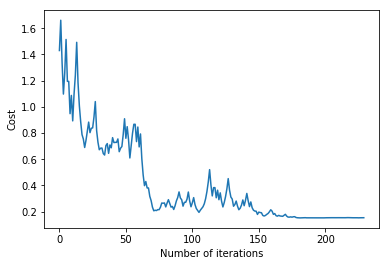

In [19]:
weights, err = annealing(X_train, y_train, lr=0.25)

plt.plot(err)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [22]:
y_train_pred = X_train @ weights

print('train nrmse: ', nrmse(y_train, y_train_pred))
print('train smape: ', smape(y_train, y_train_pred))

train nrmse:  0.154073715638551
train smape:  1.619167754822812


In [23]:
y_test_pred = X_test @ weights

print('test nrmse: ', nrmse(y_test, y_test_pred))
print('test smape: ', smape(y_test, y_test_pred))

test nrmse:  0.20810530551918238
test smape:  1.6348050123006783
